There are two types of trend: stochastic and deterministic. 

Stochastic trends can be detected using the Augmented Dickey-Fuller test.

Deterministic trends can be detected using the Cox-Stuart test. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

# Daily total female births in California, 1959

In [3]:
birth_data = pd.read_csv('data/daily-total-female-births-in-cal.csv', header=0)
birth_data.head()

,Date,"Daily total female births in California, 1959"
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


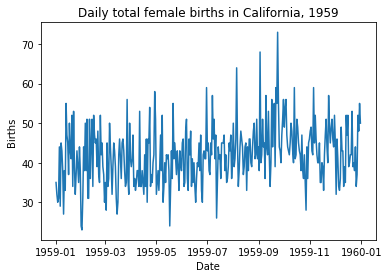

In [4]:
birth_data["Date"] = pd.to_datetime(birth_data["Date"], format="%Y-%m-%d")
plt.plot(birth_data["Date"], birth_data["Daily total female births in California, 1959"])
plt.title("Daily total female births in California, 1959")
plt.xlabel("Date")
plt.ylabel("Births")
plt.show()

Do you think there is trend in this dataset? If so, is it the stochastic or deterministic kind?

## Let's test for the stochastic kind

### Augmented Dickey Fuller Test (unit root test):

H0: The time series has stochastic trend.

Ha: The time series has no stochastic trend. 

p-value > 0.05: Fail to reject the null hypothesis (H0)

p-value <= 0.05: Reject the null hypothesis (H0). There is no stochastic trend

In [5]:
from statsmodels.tsa.stattools import adfuller

In [6]:
result = adfuller(birth_data["Daily total female births in California, 1959"])
print('p-value: %f' % result[1])

p-value: 0.000052


There is no stochastic trend here!

## Now let's test for the deterministic kind of trend

### Cox-Stuart Test (a modified sign test):

H0: There is not any trend

Ha: There is an increasing (or decreasing) trend.

p-value > 0.05: Fail to reject the null hypothesis (H0)

p-value <= 0.05: Reject the null hypothesis (H0). There is deterministic trend

#### CAREFUL: The presence or absence of trend is switched for H0 and Ha on the ADF vs CS tests

Unfortunately, this is not implemented in Python but is implemented in R. Let's go to the land of R.

API: https://rdrr.io/cran/webr/man/cox.stuart.test.html

In [7]:
webr = importr('webr')
cox_stuart_test = robjects.r('cox.stuart.test')

In [8]:
converted_vals = robjects.FloatVector(list(birth_data["Daily total female births in California, 1959"].values))
result = cox_stuart_test(converted_vals)
print(result)


	Cox-Stuart test for trend analysis

data:  
Increasing trend, p-value = 1.3826e-08




p-value = 1.3826e-08. So the births dataset does not have stochastic trend but does have deterministic trend!

Oftentimes, we must eliminate trend from the time series before applying anomaly detection algorithms.

## Stochastic trend is eliminated by $\textit{differencing}$ the time series.

## Deterministic trend is eliminated by $\textit{detrending}$ the time series. 

Because our time series has deterministic trend, let's detrend the time series. We can detrend in many ways but some prominent ways are:

1) Subtract the time series by the mean

2) Subtract the line of best fit

3) Using decomposition and subtracting the trend component

Method 3 requires us to know a little bit about STL (seasonal decomposition of time series by Loess) which we will talk about in the 2nd half of this presentation.

Let's just try method 2 for sake of time.

### Subtracting the line of best fit

In [9]:
from sklearn.linear_model import LinearRegression
import numpy as np

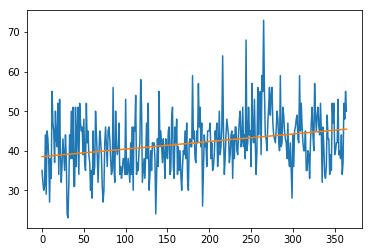

In [10]:
# fit linear model
X = [i for i in range(0, len(birth_data))]
X = np.reshape(X, (len(X), 1))
y = birth_data["Daily total female births in California, 1959"].values
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.show()

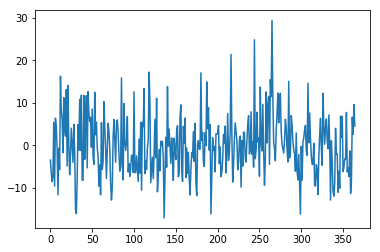

In [11]:
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(birth_data))]
# plot detrended
plt.plot(detrended)
plt.show()

Let's try the Cox-Stuart test on this now. Back to R land

In [12]:
converted_vals = robjects.FloatVector(list(detrended))
result = cox_stuart_test(converted_vals)
print(result)


	Cox-Stuart test for trend analysis

data:  
Increasing trend, p-value = 0.079417




By detrending, the p-value for the Cox-Stuart test is .079, meaning we do not reject the null hypothesis of there not being any trend.

# Airlines Data

In [13]:
airlines_data = pd.read_csv('data/international-airline-passengers.csv', header=0)
airlines_data.head()

,Month,International airline passengers: monthly totals in thousands
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


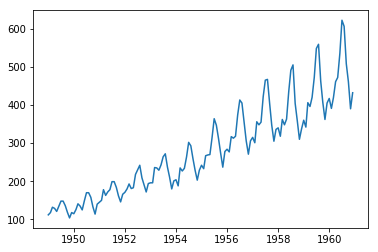

In [14]:
airlines_data["Month"] = pd.to_datetime(airlines_data["Month"], format="%Y-%m")
plt.plot(airlines_data["Month"], airlines_data["International airline passengers: monthly totals in thousands"])
plt.show()

In [15]:
result = adfuller(airlines_data["International airline passengers: monthly totals in thousands"])
print('p-value: %f' % result[1])

p-value: 0.991880


Possible stochastic trend. Is there deterministic trend?

In [16]:
converted_vals = robjects.FloatVector(list(airlines_data["International airline passengers: monthly totals in thousands"].values))
result = cox_stuart_test(converted_vals)
print(result)


	Cox-Stuart test for trend analysis

data:  
Increasing trend, p-value = 2.1176e-22




# Detrend

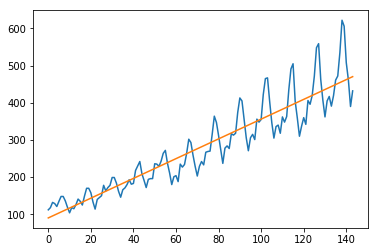

In [17]:
# fit linear model
X = [i for i in range(0, len(airlines_data))]
X = np.reshape(X, (len(X), 1))
y = airlines_data["International airline passengers: monthly totals in thousands"].values
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.show()

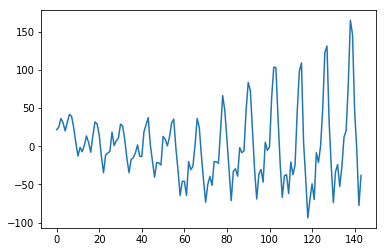

In [18]:
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(airlines_data))]
# plot detrended
plt.plot(detrended)
plt.show()

Differencing = take the difference of the observation at a particular instant with that of a previous instant

# Differencing

In [19]:
detrended_df = pd.DataFrame({"detrended_value": detrended})
detrended_df.head()

,detrended_value
0,21.690038
1,25.032854
2,36.375670
3,30.718487
4,20.061303


In [20]:
detrended_df.shift().head()

,detrended_value
0,NaN
1,21.690038
2,25.032854
3,36.375670
4,30.718487


In [21]:
airlines_data_diff = detrended_df - detrended_df.shift()
airlines_data_diff.head()

,detrended_value
0,NaN
1,3.342816
2,11.342816
3,-5.657184
4,-10.657184


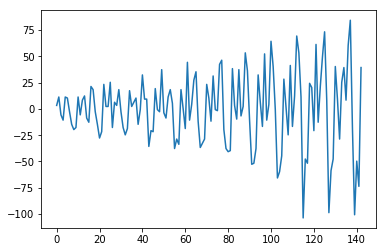

In [22]:
differenced = list(airlines_data_diff["detrended_value"].values)[1:]
plt.plot(differenced)
plt.show()

Is differencing good enough to remove all the trend? 

In [23]:
result = adfuller(differenced)
print('p-value: %f' % result[1])

p-value: 0.054213


Try differencing again!

In [24]:
airlines_data_diff.head()

,detrended_value
0,NaN
1,3.342816
2,11.342816
3,-5.657184
4,-10.657184


In [25]:
airlines_data_diff.shift().head()

,detrended_value
0,NaN
1,NaN
2,3.342816
3,11.342816
4,-5.657184


In [26]:
airlines_data_diff_twice = airlines_data_diff - airlines_data_diff.shift()
airlines_data_diff_twice.head()

,detrended_value
0,NaN
1,NaN
2,8.0
3,-17.0
4,-5.0


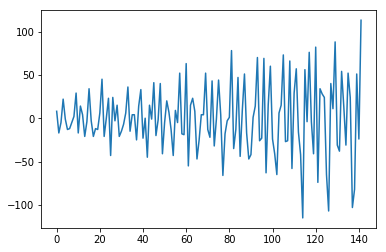

In [27]:
differenced = list(airlines_data_diff_twice["detrended_value"].values)[2:]
plt.plot(differenced)
plt.show()

In [28]:
result = adfuller(differenced)
print('p-value: %f' % result[1])

p-value: 0.000000


What about the CS test?

In [29]:
converted_vals = robjects.FloatVector(differenced)
result = cox_stuart_test(converted_vals)
print(result)


	Cox-Stuart test for trend analysis

data:  
Decreasing trend, p-value = 0.076956




By differencing, the p value for the ADF test is < .05 meaning we reject the null hypothesis where the null hypothesis is there exists stochastic trend. Thus, there is no stochastic trend.

By detrending, the p-value for the Cox-Stuart test is .076, meaning we do not reject the null hypothesis of there not being any trend.